Experimental condition 3: appraiser weights visible to artist

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import Tensor
import tensorflow_probability as tfp
import cv2
import glob
import gym
import random
from gym import Env
from gym.spaces import Discrete, Box
import math
import PIL
import PIL.ImageDraw
import PIL.Image
from PIL import ImageFont
import os
"""making tf allocate memory dynamically, to make the running of the program more efficiently"""
tf.compat.v1.enable_eager_execution()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [ ]:
"""creates relevant directory where model weights will be saved"""
os.mkdir('experimental_condition_three')

In [ ]:
"""selects 1000 images randomly from a directory of saved images, here images/images/"""
"""these images are used to train the autoencoder"""

import os
filenames = [img for img in glob.glob("images/images/*/*.jpg")]
np.random.shuffle(filenames)
filenames = filenames[:1000]
images = [cv2.imread(img) for img in filenames]
for i in range(0,len(images)):
    images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
    images[i] = cv2.resize(images[i], (400,400))
images = np.array(images)
images = images.astype('float32')/255

In [3]:
"""custom layer which produces the distribution which is sampled in the VAE"""

class Latent_features(tf.keras.layers.Layer):
    def call(self, inputs) -> Tensor:
        dist_mean, dist_log_var = inputs
        batch = tf.shape(dist_mean)[0]
        dim = tf.shape(dist_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return dist_mean + tf.exp(0.5 * dist_log_var) * epsilon

In [4]:
class VAE(tf.keras.Model):
    
    """builds encoder and decoder sub-networks"""
    
    def __init__(self):
        super(VAE, self).__init__()
        self.conv_layer_steps = [2,2,2,2]
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
        autoencoder_input = keras.Input(shape=(400,400,3))
        encoded_img = self.encoder(autoencoder_input)[2]
        decoded_img = self.decoder(encoded_img)
        self.autoencoder = keras.Model(autoencoder_input, decoded_img)
    
    """custom call function necessary for custom keras model"""
    def call(self, image):
        encoded = self.encoder(image)[2]
        decoded = self.decoder(encoded)
        return decoded
    
    """utility function for batch norm and leakyrelu"""
    def activation_block(self, inputs) -> Tensor:
        BN = tf.keras.layers.BatchNormalization(momentum=0.99) (inputs)
        activated = tf.keras.layers.LeakyReLU()(BN)
        return activated
    
    """implements skip connection for the resnet component of the architecture"""
    def residual_block(self, inputs: Tensor, scale_change: bool, polarity, kernel_size = 2, filters = 64, stride_size = 2) -> Tensor:
        #POLARITY IS 0 IF DOWNSCALING (ENCODER) 1 IF UPSCALING (DECODER)
        if polarity == 0:
            output_1 = tf.keras.layers.Conv2D(filters, (kernel_size, kernel_size), strides = (1 if not scale_change else stride_size), padding = 'same') (inputs)
            output_1 = self.activation_block(output_1)
            output_1 = tf.keras.layers.Conv2D(filters, (kernel_size, kernel_size), strides = (1), padding = 'same') (output_1)
            if scale_change == True:
                inputs = tf.keras.layers.Conv2D(filters, (kernel_size, kernel_size), strides = (stride_size), padding = 'same') (inputs)
        
        else:
            output_1 = tf.keras.layers.Conv2DTranspose(filters, (kernel_size, kernel_size), strides = (1 if not scale_change else stride_size), padding = 'same') (inputs)
            output_1 = self.activation_block(output_1)
            output_1 = tf.keras.layers.Conv2DTranspose(filters, (kernel_size, kernel_size), strides = (1), padding = 'same') (output_1)
            if scale_change == True:
                inputs = tf.keras.layers.Conv2DTranspose(filters, (kernel_size, kernel_size), strides = (stride_size), padding = 'same') (inputs)
        
        output_2 = tf.keras.layers.Add()([inputs, output_1])
        output_2 = self.activation_block(output_2)
        
        return(output_2)
        
    """returns the encoder model, a sub-architecture of the autoencoder"""
    def build_encoder(self):
        num_filters = 32
        conv_layer_steps = self.conv_layer_steps
        E_input = tf.keras.layers.Input(shape = (400,400,3), name = 'original_image')
        E = tf.keras.layers.Conv2D(num_filters, (1,1), strides=(1), padding = 'same') (E_input)
        E = self.activation_block(E)
        
        block_depths = [2,5,5,2]
        filters = [32,64,64,128]
        
        for i in range(0,len(block_depths)):
            for j in range(0,block_depths[i]):
                E = self.residual_block(E, (j==0 and i!=0), 0, 2, filters[i], 2)

        
            
        self.reshape_dims = E.shape
            
        E = tf.keras.layers.Flatten() (E)
        
        self.flatten_dims = E.shape
        
        E = (tf.keras.layers.LeakyReLU()) (E)
        
        distribution_mean = tf.keras.layers.Dense(16, name='mean')(E)
        distribution_variance = tf.keras.layers.Dense(16, name='log_variance')(E)
        latent_encoding = Latent_features()([distribution_mean, distribution_variance])
        
        
        encoder = keras.Model(E_input, [distribution_mean, distribution_variance, latent_encoding], name="encoder")
        
                
        return encoder
    
    """returns the decoder model, a sub-network for autoencoder architecture"""
    def build_decoder(self):
        num_filters = 256
        conv_layer_steps = self.conv_layer_steps
        decoder_input = keras.Input(shape=(16,))
        D = tf.keras.layers.LeakyReLU() (decoder_input)
        D = (tf.keras.layers.Dense(self.flatten_dims[1])) (D)
        D = (tf.keras.layers.LeakyReLU()) (D)
        D = (tf.keras.layers.Reshape((self.reshape_dims[1], self.reshape_dims[2], self.reshape_dims[3]))) (D)
        
        block_depths = [2,5,5,2]
        filters = [128,64,64,32]
        
        for i in range(0,len(block_depths)):
            for j in range(0,block_depths[i]):
                D = self.residual_block(D, (j==0 and i!=0), 1, 2, filters[i], 2)
            
        D = tf.keras.layers.Conv2DTranspose(3, (1,1), strides = (1), padding = 'same') (D)
        D = self.activation_block(D)
        
        
        decoded = (tf.keras.layers.Activation('sigmoid')) (D)
        
        decoder = tf.keras.Model(inputs = decoder_input, outputs = decoded)
        
        return decoder

    
    """necessary for loss trackers used for custom loss function"""
    @property
    def metrics(self):
        return [self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            mean, log_var, latent = self.encoder(data)
            reconstruction = self.decoder(latent)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),}


In [5]:
"""compiling the VAE with RMSprop, and a lower learning rate than during the VAE training loop"""
opt = tf.keras.optimizers.RMSprop(learning_rate = 0.0000005)
vae = VAE()

vae.compile(optimizer=opt)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [6]:
"""training VAE"""
vae.fit(images, epochs = 20, batch_size = 4)

In [14]:
class Painting_Env(gym.Env):
  def __init__(self, paintings_per_loop = 100, maximum_acceptable_loss = 0.005):

    super().__init__()
    self.action_space = Box(low = 0, high = 1, shape = (64,64,3))
    self.state_img = np.zeros((64,64,3))
    self.state_weights = np.zeros((1,366))
    self.state = (self.state_img, self.state_weights)
    self.paintings_per_loop = paintings_per_loop
    self.paintings_per_loop_original = self.paintings_per_loop
    self.maximum_acceptable_loss = maximum_acceptable_loss
    



  def step(self, action):
    """state contains both image and weights"""
    self.state_img = action.squeeze()
    original_img = cv2.resize(self.state_img.squeeze(), (400,400))
    reconstructed_orig = vae(original_img.reshape(1,400,400,3)).numpy().squeeze()

    current_weights = vae.get_weights()
    """training vae for one train step on the original img"""

    vae.train_step(original_img.reshape(1,400,400,3))

    new_weights = vae.get_weights()

    weight_diff = []

    reconstructed = vae(original_img.reshape(1,400,400,3)).numpy().squeeze()
    """finding weighted avg of weight differences"""

    for i in range(len(current_weights)):
      if current_weights[i].ndim != 0:
        weight_diff.append((tf.math.reduce_mean(np.abs(tf.keras.losses.MSE(current_weights[i],new_weights[i]).numpy())).numpy())*(len(current_weights)/2 - (abs(i-len(current_weights)/2))))

    """making this a single number"""

    weight_diff = tf.math.reduce_mean(weight_diff).numpy()

    loss_val = tf.math.reduce_mean(tf.keras.losses.MSE(original_img, reconstructed)).numpy()
    """if loss is above maximum acceptable loss, fix weight difference and revert changes to vae
    also make current state weights previous vae weights"""

    if loss_val > self.maximum_acceptable_loss:
      weight_diff = 0.0001
      vae.set_weights(current_weights)
      new_weights = current_weights
    else:
      weight_diff *= 1e9

    state_weights = []
    for i in range(len(current_weights)):
      if current_weights[i].ndim != 0:
        state_weights.append(tf.math.reduce_mean(new_weights[i]).numpy())
    
    state_weights = np.array(state_weights, dtype=np.float32)
    state_weights = state_weights.reshape(1,366)

    self.reconstructed = reconstructed

    reconstruction_loss = np.abs(original_img - reconstructed)
    img_loss = np.abs(tf.keras.losses.binary_crossentropy(original_img, reconstructed).numpy())
    loss = reconstruction_loss
    """ensuring no division by 0"""
    loss[loss == 0] = 0.00000001

    loss = cv2.resize(loss, (64,64))


    reward = -(loss/weight_diff)
    self.paintings_per_loop -= 1
    self.reward = reward
    self.state_weights = state_weights
    """state is a tuple containing image and weights"""
    self.state = (self.state_img, self.state_weights)
    self.state = np.array(self.state)

    if self.paintings_per_loop <= 0:
      done = True
    else:
      done = False
    self.loss = loss
    info = {}
    return self.state, reward, done, info


  def render(self, mode = None):
    """utility function to render environment at any time step"""
    original_img = (cv2.resize(self.state_img.squeeze(), (400,400)))
    img = PIL.Image.fromarray(((original_img)*255).astype('uint8'))
    reconstructed = ((self.reconstructed*255).astype('uint8')).squeeze()
    if mode == 'human':
      d = PIL.ImageDraw.Draw(img)
      font = ImageFont.load_default()
      y = 0
      _, height = d.textsize("W", font)
      d.text((0, y), f"Reward: {tf.math.reduce_mean(self.reward)}", fill=(0, 255, 0))
      y+=height
      d.text((0, y), f"Loss: {tf.math.reduce_mean(self.loss)}", fill=(0, 255, 0))
      y+=height
      reconstructed = ((self.reconstructed*255).astype('uint8')).squeeze()
      img = np.array(img)
      img = np.concatenate((img, reconstructed), axis = 1)
    else:
      img = np.array(img)
      img = np.concatenate((img, reconstructed), axis = 1)      
    return (np.array(img))


  def reset(self):
    self.paintings_per_loop = self.paintings_per_loop_original
    return self.state

In [15]:
"""registering the gym environment"""
gym.envs.registration.register(
    id='painting_environment-v1',
    entry_point=f'{__name__}:Painting_Env',
)

In [16]:
class ppo_memory:
  def __init__(self, batch_size):
    self.states = []
    self.probabilities = [] 
    self.terminal_memory = []
    self.values = []
    self.actions = []
    self.rewards = []
    self.batch_size = batch_size

  """storing memories"""
  def store_memory(self, state, action, probabilities, values, reward, done):
    self.states.append(state)
    self.actions.append(action)
    self.probabilities.append(probabilities)
    self.values.append(values)
    self.rewards.append(reward)
    self.terminal_memory.append(done)

  """clearing all memory, happens after a completed learning cycle"""
  def clear_memory(self):
    self.states = []
    self.probabilities=[]
    self.rewards = []
    self.terminal_memory = []
    self.values = []
    self.actions = []

  """returning states, actions, values (for the critic), probabilities, and the indices of these items"""
  def generate_batches(self):
    number_states = len(self.states)
    batch_start_points = np.arange(0, number_states, self.batch_size)

    indices = np.arange(number_states, dtype=np.int64)

    batches = [indices[i:i+self.batch_size] for i in batch_start_points]

    return np.array(self.states), np.array(self.actions), np.array(self.probabilities), np.array(self.values), np.array(self.rewards),\
    np.array(self.terminal_memory), batches



In [17]:
"""custom keras layer for the actor network, returns a gaussian distribution over every
colour channel for every pixel"""
class gaussian_dist(tf.keras.layers.Layer):
  def call(self, inputs) -> Tensor:
    means, stddevs = inputs
    dist = tfp.distributions.Normal(loc = means, scale = stddevs**2)
    return dist

In [18]:
class actor_network(tf.keras.Model):
  
  def __init__(self, n_actions, conv_layer_params=None, conv_transpose_params=None, lstm_size = 366, name = 'actor', checkpointdir = 'tmp/ddpg',
               batch_size = 16):
    
    super(actor_network, self).__init__()

    self.n_actions = n_actions
    self.model_name = name

    self.checkpoint_dir = checkpointdir
    self.checkpoint_file = os.path.join(self.model_name+'_ppo.h5')
    self.conv_layer_params = conv_layer_params
    flatten_dims = None
    """finding the flattened dimensions for the bottleneck of the actor (after the LSTM section)"""
    for i in range(0,len(conv_layer_params)):
      if not flatten_dims:
        flatten_dims = conv_layer_params[i][2]
      else:
        flatten_dims *= conv_layer_params[i][2]

    self.reshape_dims = np.array([n_actions[0],n_actions[1]])/flatten_dims
    self.reshape_dims = self.reshape_dims.astype(int)
    flatten_dims = (self.reshape_dims[0]*self.reshape_dims[1])*conv_layer_params[-1][0]
    self.flatten_dims = flatten_dims
    input_encoder = []

    """building an input encoder, which is convolutional"""
    for config in conv_layer_params:
      (filters, kernel_size, strides) = config
      input_encoder.append(
            tf.keras.layers.Conv2D(
                filters=filters,
                kernel_size=kernel_size,
                strides=strides,
                dilation_rate=(1,1),
                padding = 'same'))
      input_encoder.append(tf.keras.layers.LeakyReLU())
      input_encoder.append(tf.keras.layers.Dropout(0.2))
    
    
    lstm_network = []
    """building 2 layer LSTM layer for image representations"""
    for i in range(2):
      lstm_network.append(tf.keras.layers.LSTM(128, return_sequences = True, stateful = True))
    
    img_dense = tf.keras.layers.Dense(lstm_size)

    """seperate LSTM layer for the weights, this is a seperate input"""
    lstm_weights_network = tf.keras.layers.LSTM(lstm_size, return_sequences=True, stateful=True)

    """these two layers add the weights LSTM output and the image LSTM output"""
    add_layer = tf.keras.layers.Add()

    combined_dense = tf.keras.layers.Dense(flatten_dims)


    output_encoder = []


    """building an output decoder, which is made of deconvolutional layers"""
    for config in conv_transpose_params:
      (filters, kernel_size, strides) = config
      output_encoder.append(
            tf.keras.layers.Conv2DTranspose(
                filters=filters,
                kernel_size=kernel_size,
                strides=strides,
                dilation_rate=(1,1),
                padding = 'same'))
      output_encoder.append(tf.keras.layers.LeakyReLU())
      output_encoder.append(tf.keras.layers.Dropout(0.2))
    

    output_encoder_means = tf.keras.layers.Conv2DTranspose(filters = 3, kernel_size = (1,1), strides = (1,1), dilation_rate=(1,1), padding='same', activation = 'sigmoid')
    output_encoder_stddevs = tf.keras.layers.Conv2DTranspose(filters = 3, kernel_size = (1,1), strides = (1,1), dilation_rate=(1,1), padding='same', activation = 'sigmoid')
    output_encoder_dist = gaussian_dist()

    self.input_encoder = input_encoder
    self.lstm_network = lstm_network
    self.lstm_weights_network = lstm_weights_network
    self.add_layer = add_layer
    self.combined_dense = combined_dense
    self.output_encoder = output_encoder
    self.output_encoder_means = output_encoder_means
    self.output_encoder_stddevs = output_encoder_stddevs
    self.output_encoder_dist = output_encoder_dist
    self.img_dense = img_dense

  def call(self, state):
      """seperating state into image and weights, reshaping image for lstm"""
      state_img = state[0]
      if tf.rank(state_img) == 3:
        state_img = tf.reshape(state_img, (1,1,self.n_actions[0],self.n_actions[1],self.n_actions[2]))
      else:
        state_img = tf.reshape(state_img, (1,len(state_img),self.n_actions[0],self.n_actions[1],self.n_actions[2]))
      state_weights = state[1]
      """reshapeing weights for lstm"""
      state_weights = tf.reshape(state_weights, (1,len(state_weights), len(state_weights[0])))
      action_value = self.input_encoder[0](state_img)
      input_shape = np.shape(action_value)
      """encoding image"""
      for i in range(1,len(self.input_encoder)):
        action_value = self.input_encoder[i](action_value)
      """reshaping image encoding for lstm layer and putting it through lstm layer"""
      action_value = tf.reshape(action_value, (1,input_shape[1],self.flatten_dims))
      for layer in self.lstm_network:
        action_value = layer(action_value)
      """combining image representation with weights representation"""
      action_value = self.img_dense(action_value)
      weights_value = self.lstm_weights_network(state_weights)
      added_value = self.add_layer([action_value, weights_value])
      action_value = self.combined_dense(action_value)
      """reshaping output for output encoder and putting it through output encoder"""
      action_value = tf.reshape(action_value, (input_shape[1],self.reshape_dims[0],self.reshape_dims[1],256))
      for layer in self.output_encoder:
        action_value = layer(action_value)
      """creating distribution"""
      action_value_means = (self.output_encoder_means(action_value))
      action_value_stddevs = (self.output_encoder_stddevs(action_value))
      dist_channel = self.output_encoder_dist([action_value_means, action_value_stddevs])


      return dist_channel

In [19]:
class critic_network(tf.keras.Model):

  def __init__(self, n_actions, conv_layer_params=None, conv_transpose_params=None, lstm_size = None, name = 'critic', checkpointdir = 'tmp/ddpg'):
    
    super(critic_network, self).__init__()

    self.n_actions = n_actions
    self.model_name = name

    self.checkpoint_dir = checkpointdir
    self.checkpoint_file = os.path.join(self.model_name+'_ppo.h5')
    self.conv_layer_params = conv_layer_params
    flatten_dims = None
    """finding the flattened dimensions for the bottleneck of the critic (after the LSTM section)"""
    for i in range(0,len(conv_layer_params)):
      if not flatten_dims:
        flatten_dims = conv_layer_params[i][2]
      else:
        flatten_dims *= conv_layer_params[i][2]

    self.reshape_dims = np.array([n_actions[0],n_actions[1]])/flatten_dims
    self.reshape_dims = self.reshape_dims.astype(int)
    flatten_dims = (self.reshape_dims[0]*self.reshape_dims[1])*conv_layer_params[-1][0]
    self.flatten_dims = flatten_dims

    """building an input encoder, which is convolutional"""
    input_encoder = []
    for config in conv_layer_params:
      (filters, kernel_size, strides) = config
      input_encoder.append(
            tf.keras.layers.Conv2D(
                filters=filters,
                kernel_size=kernel_size,
                strides=strides,
                dilation_rate=(1,1),
                activation=tf.keras.activations.relu,
                padding = 'same'))
      input_encoder.append(tf.keras.layers.BatchNormalization(momentum=0.99))
      input_encoder.append(tf.keras.layers.LeakyReLU())
      input_encoder.append(tf.keras.layers.Dropout(0.2))


    lstm_network = []
    """building 2 layer LSTM layer for image representations"""
    for i in range(2):
      lstm_network.append(tf.keras.layers.LSTM(128, return_sequences = True, stateful = True))
    
    img_dense = tf.keras.layers.Dense(lstm_size)
    """seperate LSTM layer for the weights, this is a seperate input"""

    lstm_weights_network = tf.keras.layers.LSTM(lstm_size, return_sequences=True, stateful=True)
    """these two layers add the weights LSTM output and the image LSTM output"""

    add_layer = tf.keras.layers.Add()

    combined_dense = tf.keras.layers.Dense(flatten_dims)

    output_encoder = []
    """building an output decoder, which is made of deconvolutional layers"""

    for config in conv_transpose_params:
      (filters, kernel_size, strides) = config
      output_encoder.append(
            tf.keras.layers.Conv2DTranspose(
                filters=filters,
                kernel_size=kernel_size,
                strides=strides,
                dilation_rate=(1,1),
                padding = 'same'))
      output_encoder.append(tf.keras.layers.BatchNormalization(momentum=0.99))
      output_encoder.append(tf.keras.layers.LeakyReLU())
      output_encoder.append(tf.keras.layers.Dropout(0.2))
    
    output_encoder.append(tf.keras.layers.Conv2DTranspose(filters =3, kernel_size = (1,1), strides = (1,1), dilation_rate=(1,1),padding = 'same', activation='sigmoid'))
    
    self.input_encoder = input_encoder
    self.lstm_network = lstm_network
    self.output_encoder = output_encoder
    self.lstm_weights_network = lstm_weights_network
    self.add_layer = add_layer
    self.combined_dense = combined_dense
    self.img_dense = img_dense

  def call(self, state):
      """seperating state into image and weights, reshaping image for lstm"""
      state_img = state[0]
      if tf.rank(state_img) == 3:
        state_img = tf.reshape(state_img, (1,1,self.n_actions[0],self.n_actions[1],self.n_actions[2]))
      else:
        state_img = tf.reshape(state_img, (1,len(state_img),self.n_actions[0],self.n_actions[1],self.n_actions[2]))
      state_weights = state[1]
      """reshapeing weights for lstm"""
      state_weights = tf.reshape(state_weights, (1,len(state_weights), len(state_weights[0])))
      action_value = self.input_encoder[0](state_img)
      input_shape = np.shape(action_value)
      """encoding image"""
      for i in range(1,len(self.input_encoder)):
        action_value = self.input_encoder[i](action_value)
      """reshaping image encoding for lstm layer and putting it through lstm layer"""
      action_value = tf.reshape(action_value, (1,input_shape[1],self.flatten_dims))
      for layer in self.lstm_network:
        action_value = layer(action_value)
      """combining image representation with weights representation"""
      action_value = self.img_dense(action_value)
      weights_value = self.lstm_weights_network(state_weights)
      added_value = self.add_layer([action_value, weights_value])
      action_value = self.combined_dense(action_value)
      """reshaping output for output encoder and putting it through output encoder"""
      action_value = tf.reshape(action_value, (input_shape[1],self.reshape_dims[0],self.reshape_dims[1],256))
      for layer in self.output_encoder:
        action_value = layer(action_value)

      return action_value

In [20]:
class ppo_agent:
  def __init__(self, n_actions, conv_layer_params, conv_transpose_params, lstm_size=366, gamma = 0.7, alpha = 0.0003, policy_clip = 0.2, batch_size = 16,
               n_epochs = 5, gae_lambda = 0.95):
    
    self.gamma = gamma
    self.n_actions = n_actions
    self.alpha = alpha
    self.policy_clip = policy_clip
    self.batch_size = batch_size
    self.N = N
    self.n_epochs = n_epochs
    self.gae_lambda = gae_lambda

    self.actor = actor_network(n_actions=(64,64,3), conv_layer_params=conv_layer_params, conv_transpose_params=conv_transpose_params, lstm_size=lstm_size,
                               name=os.path.join('Experimental_condition_three','actor_network'))
    self.critic = critic_network(n_actions=(64,64,3), conv_layer_params=conv_layer_params, conv_transpose_params=conv_transpose_params, lstm_size=lstm_size,
                               name=os.path.join('Experimental_condition_three','critic_network'))
    
    self.actor.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=alpha))

    self.critic.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=alpha))

    self.memory = ppo_memory(self.batch_size)

  def remember(self, state, action, probs, vals, reward, done):
    self.memory.store_memory(state, action, probs, vals, reward, done)

  def save_models(self):
    print('saving models')
    self.actor.save_weights(self.actor.checkpoint_file)
    self.critic.save_weights(self.critic.checkpoint_file)
    vae.autoencoder.save_weights(os.path.join('Experimental_condition_three','updated_appraiser.h5'))


  def load_models(self):
    print('loading models')
    self.actor.load_weights(self.actor.checkpoint_file)
    self.critic.load_weights(self.critic.checkpoint_file)
    vae.autoencoder.load_weights(os.path.join('Experimental_condition_three','updated_appraiser.h5'))


  def choose_action(self, observation):
    observation_img = tf.convert_to_tensor(observation[0])
    observation_weights = tf.convert_to_tensor(observation[1])
    actions = self.actor([observation_img, observation_weights])
    img = (actions.sample())
    action = img

    value = self.critic([observation_img, observation_weights])

    probs = actions.log_prob(img).numpy()

    return (action.numpy()).astype(np.float32),\
    probs,\
    value.numpy()

  
  def learn(self):
    for _ in range(n_epochs):
      
      state_array, action_array, old_probs_array,\
       vals_array, reward_array, done_array, batches =  self.memory.generate_batches()
      
      
      values = tf.squeeze(vals_array).numpy()
      
      
      advantage = np.zeros(shape=np.shape(reward_array), dtype=np.float32)

      """calculating advantage for future time steps from each point in batch"""
      for x in range(len(reward_array)-1):
        discount = 1
        advantage_timestep = 0
        for y in range(x, len(reward_array)-1):
           advantage_timestep += discount*(reward_array[y] + self.gamma*values[y+1]*\
                            (1-int(done_array[y])) - values[y])
           discount *= self.gamma*self.gae_lambda
        advantage[x] = advantage_timestep

      """training per batch"""
      for batch in batches:
        with tf.GradientTape() as t1, tf.GradientTape() as t2:
          batch = np.array(batch)
          """images and weights arrays have to be reshaped to take them from ragged numpy nested sequence to proper array"""
          states_imgs_ragged = state_array[batch][:,0]
          states_imgs_clean = np.zeros((len(batch),64,64,3))
          for i in range(len(states_imgs_ragged)):
            states_imgs_clean[i] = states_imgs_ragged[i]
          states_imgs_clean = tf.convert_to_tensor(states_imgs_clean)
          states_weights_ragged = state_array[batch][:,1]
          states_weights_clean = np.zeros((len(batch),366))
          for i in range(len(states_weights_ragged)):
            states_weights_clean[i] = states_weights_ragged[i]
          states_weights_clean = tf.convert_to_tensor(states_weights_clean)
          old_probs = tf.convert_to_tensor(old_probs_array[batch])

          actions = tf.convert_to_tensor(action_array[batch])
          """finding the distributions and values per batch of states"""
          dist = self.actor([states_imgs_clean, states_weights_clean])

          critic_value = tf.squeeze(self.critic([states_imgs_clean, states_weights_clean]))
          

          new_probs = dist.log_prob(actions)
          """finding new probability and comparing it to old"""
          prob_ratio = tf.exp(new_probs) / tf.exp(old_probs)

          weighted_probs = advantage[batch] * prob_ratio
          """clipping values"""
          weighted_clipped_probs = tf.clip_by_value(weighted_probs, 1-self.policy_clip, 1+self.policy_clip)*advantage[batch]

          returns = advantage[batch]+values[batch]
          """calculating losses"""
          critic_loss = ((returns - critic_value)**2)
          critic_loss = tf.math.reduce_mean(critic_loss)

          actor_loss = tf.math.reduce_mean(-tf.math.minimum(weighted_probs, weighted_clipped_probs))
          total_loss = actor_loss + 0.5*critic_loss

          """utility function for fixing None gradients, which happens sometimes with seperate inputs.
          This is an expected behaviour in this variant"""
          def _compute_actor_gradients(tensor, var_list):
            grads = t2.gradient(tensor, var_list)
            return [grad if grad is not None else tf.zeros_like(var)
                  for var, grad in zip(var_list, grads)]

          def _compute_critic_gradients(tensor, var_list):
            grads = t1.gradient(tensor, var_list)
            return [grad if grad is not None else tf.zeros_like(var)
                  for var, grad in zip(var_list, grads)]

          
          """training actor"""
          actor_gradient = _compute_actor_gradients(actor_loss, self.actor.trainable_variables)
          self.actor.optimizer.apply_gradients(zip(actor_gradient, self.actor.trainable_variables))

          """training critic"""
          critic_gradient = _compute_critic_gradients(critic_loss, self.critic.trainable_variables)
          self.critic.optimizer.apply_gradients(zip(critic_gradient, self.critic.trainable_variables))

    """clearing memory after training"""
    self.memory.clear_memory()



Below cell is the equivalent of a config file

In [21]:
"""change this to reload models later"""
load_models = False
"""frequency with which to display outputs"""
disp_frequency = 25
"""whether to display progress in terms of score"""
verbose = False

In [22]:
"""creating environment"""
env = gym.make('painting_environment-v1')
processed_imgs_two = np.zeros((1,400,800,3), dtype = int)
"""number of actions taken between learning"""
N = 10
"""number of epochs per learning iteration"""
n_epochs = 8
"""learning rate for actor and critic"""
alpha = 0.0001
"""batch size for actor/critic training"""
batch_size = 8
learn_iters = 0
avg_score = 0
n_steps = 0
a = 0
agent = ppo_agent(n_actions=env.action_space.shape, 
                      conv_layer_params =[(64, 2, 2), (128, 2, 2),(128,1,1),(128,1,1),(256,1,1)], 
                      conv_transpose_params=[(256,1,1),(128,1,1),(128,1,1),(128,2,2),(64,2,2)],
                      batch_size = batch_size, n_epochs = n_epochs, alpha = alpha)
if load_models:
        agent.actor(np.zeros((1,64,64,3)))
        agent.critic(np.zeros((1,64,64,3)))
        agent.load_models()
"""how many episodes"""
n_episodes = 1000
best_score = env.reward_range[0]
steps_since_improvement = 0
score_history = []
avg_score_history = []#list(np.load(os.path.join('condition_three','score_history_weights_invis_reviewed.npy')))

C:\Users\joe\Miniconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


learning


C:\Users\joe\Miniconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


learning
rendering


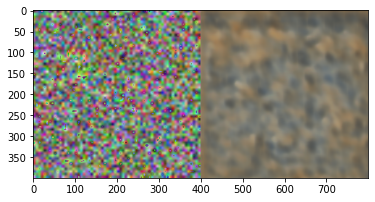

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


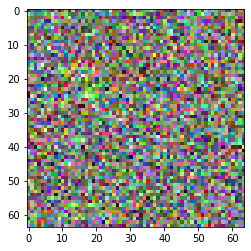

-1850.1774
learning
learning
learning
rendering


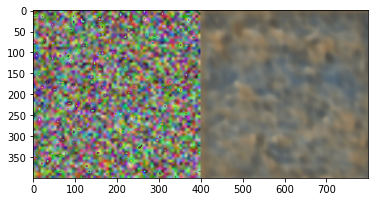

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


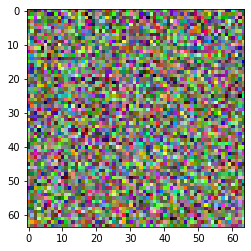

-1878.2233
learning
learning
rendering


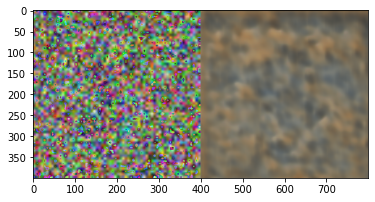

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


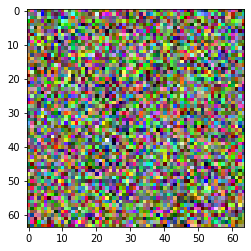

-2160.299
learning
learning
learning
rendering


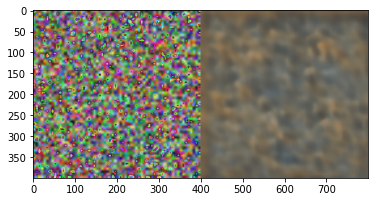

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


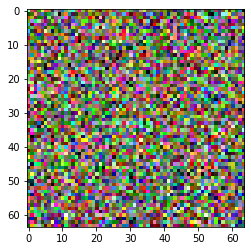

-2399.4575
saving models
learning
learning


KeyboardInterrupt: 

In [24]:
for i in range(n_episodes):
  observation = env.reset()
  done = False
  score = 0
  while not done:
    action, probs, value = agent.choose_action(observation)
    observation_, reward, done, info = env.step(action)
    n_steps += 1
    score = (tf.reduce_mean(reward)).numpy()
    score_history.append(score)
    agent.remember(observation,\
                   action, probs, value, reward, done)
    
    
    if n_steps % N == 0:
      print('learning')
      agent.learn()
      learn_iters += 1
    
    if n_steps % disp_frequency == 0:
      print('rendering')
      plt.figure()
      plt.imshow(env.render())
      plt.pause(1)
      plt.figure()
      plt.imshow(action.squeeze())
      plt.pause(1)
      print(score)
        
    observation = observation_
  
  agent.save_models()
  avg_score = np.mean(score_history)
  avg_score_history.append(avg_score)
  score_history = []
  if verbose:
      print('episode ',str(i), 'score %1f' %score, 'avg_score %1f' %avg_score, 'time steps %1f' %n_steps, '\n learning iters %1f' %learn_iters)